In [1]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Medical MNIST - X Ray image classification

> Authors: IAU students in 2021 (bonus assignment)

### Dataset

Link: https://www.kaggle.com/andrewmvd/medical-mnist

#### Prerequisite
Download the dataset mentioned above and unzip it in `./data/medical_mnist` directory.

### References
- https://towardsdatascience.com/exploratory-data-analysis-8fc1cb20fd15<BR>
- https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2<BR>
- https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_convolutional_neuralnetwork/<BR>
- https://www.kaggle.com/frostnt/medical-mnist-pytorch<BR>

# 01 Exploratory Data Analysis

Exploratory Data Analysis (EDA) refers to the critical process of performing initial investigations on data to discover patterns, spot anomalies, test hypotheses, and check assumptions using summary statistics and graphical representations.

> Note: The dataset may contain typos (e.g., 'bengin' instead of 'benign').

In [ ]:
!pip install scikit-image

In [1]:
import os
import os.path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

In [2]:
# print classes of images in dataset directory
data_dir = './data/medical_mnist'
classes = os.listdir(data_dir)
print(classes)

['AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand', 'HeadCT']


In [3]:
# observe the shape of a sample image from one of the classes
io.imread("./data/medical_mnist/AbdomenCT/000000.jpeg").shape

(64, 64)

In [4]:
# count the number of images per class and total dataset length
print('number of images in AbdomenCT: ' + str(len(os.listdir(data_dir + '/AbdomenCT'))))
print('number of images in BreastMRI: ' + str(len(os.listdir(data_dir + '/BreastMRI'))))
print('number of images in ChestCT: ' + str(len(os.listdir(data_dir + '/ChestCT'))))
print('number of images in CXR: ' + str(len(os.listdir(data_dir + '/CXR'))))
print('number of images in Hand: ' + str(len(os.listdir(data_dir + '/Hand'))))
print('number of images in HeadCT: ' + str(len(os.listdir(data_dir + '/HeadCT'))))
print('total length of dataset: ' + str(
    len(os.listdir(data_dir + '/AbdomenCT')) + len(os.listdir(data_dir + '/BreastMRI')) +
    len(os.listdir(data_dir + '/ChestCT')) + len(os.listdir(data_dir + '/CXR')) +
    len(os.listdir(data_dir + '/Hand')) + len(os.listdir(data_dir + '/HeadCT'))))

number of images in AbdomenCT: 10000
number of images in BreastMRI: 8954
number of images in ChestCT: 10000
number of images in CXR: 10000
number of images in Hand: 10000
number of images in HeadCT: 10000
total length of dataset: 58954


First, we look at some images from each class to get a better understanding of the data.

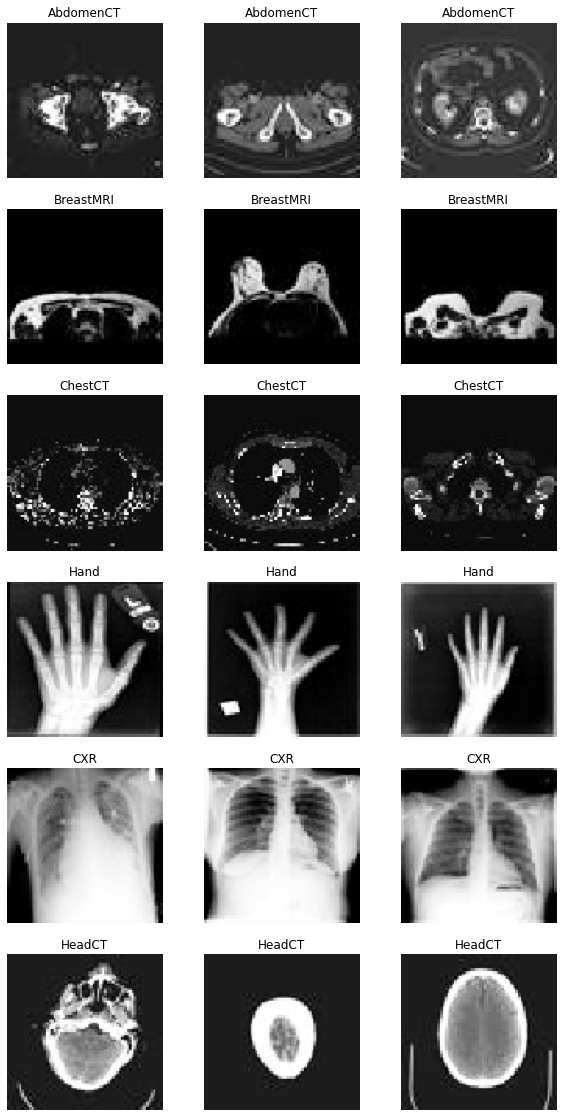

In [5]:
# get the list of jpeg images from each sub-folder
AbdomenCT_imgs = [fn for fn in os.listdir(f'{data_dir}/AbdomenCT') if fn.endswith('.jpeg')]
BreastMRI_imgs = [fn for fn in os.listdir(f'{data_dir}/BreastMRI') if fn.endswith('.jpeg')]
ChestCT_imgs = [fn for fn in os.listdir(f'{data_dir}/ChestCT') if fn.endswith('.jpeg')]
CXR_imgs = [fn for fn in os.listdir(f'{data_dir}/CXR') if fn.endswith('.jpeg')]
Hand_imgs = [fn for fn in os.listdir(f'{data_dir}/Hand') if fn.endswith('.jpeg')]
HeadCT_imgs = [fn for fn in os.listdir(f'{data_dir}/HeadCT') if fn.endswith('.jpeg')]

# randomly select 3 from each class
select_AbdomenCT_imgs = np.random.choice(AbdomenCT_imgs, 3, replace=False)
select_BreastMRI_imgs = np.random.choice(BreastMRI_imgs, 3, replace=False)
select_ChestCT_imgs = np.random.choice(ChestCT_imgs, 3, replace=False)
select_CXR_imgs = np.random.choice(CXR_imgs, 3, replace=False)
select_Hand_imgs = np.random.choice(Hand_imgs, 3, replace=False)
select_HeadCT_imgs = np.random.choice(HeadCT_imgs, 3, replace=False)

# plotting all images in a 6x3 grid
fig = plt.figure(figsize=(10, 20))
for i in range(18):
    if i < 3:
        fp = f'{data_dir}/AbdomenCT/{select_AbdomenCT_imgs[i]}'
        label = 'AbdomenCT'
    elif i >= 3 and i < 6:
        fp = f'{data_dir}/BreastMRI/{select_BreastMRI_imgs[i - 3]}'
        label = 'BreastMRI'
    elif i >= 6 and i < 9:
        fp = f'{data_dir}/ChestCT/{select_ChestCT_imgs[i - 6]}'
        label = 'ChestCT'
    elif i >= 9 and i < 12:
        fp = f'{data_dir}/Hand/{select_CXR_imgs[i - 9]}'
        label = 'Hand'
    elif i >= 12 and i < 15:
        fp = f'{data_dir}/CXR/{select_Hand_imgs[i - 12]}'
        label = 'CXR'
    else:
        fp = f'{data_dir}/HeadCT/{select_HeadCT_imgs[i - 15]}'
        label = 'HeadCT'
    ax = fig.add_subplot(6, 3, i + 1)

    # load image with target size (100,100) and in grayscale
    fn = image.load_img(fp, target_size=(100, 100), color_mode='grayscale')
    plt.imshow(fn, cmap='Greys_r')
    plt.title(label)
    plt.axis('off')

plt.show()

## Converting Images to Numpy Arrays

For further analysis, it is beneficial to convert images into numpy arrays, which provide a numerical representation suitable for machine learning. Here, we define a function that converts images into a 1D vector representation.

In [6]:
# defined image size from img.shape
IMAGE_SIZE = 64


# making n X m matrix [3]
def img2np(path, list_of_filename, size=(IMAGE_SIZE, IMAGE_SIZE)):
    # iterating through each file
    for fn in list_of_filename:
        fp = path + fn
        current_image = image.load_img(fp, target_size=size,
                                       color_mode='grayscale')
        # convert image to a matrix
        img_ts = image.img_to_array(current_image)
        # turn that into a vector / 1D array
        img_ts = [img_ts.ravel()]
        try:
            # concatenate different images
            full_mat = np.concatenate((full_mat, img_ts))
        except UnboundLocalError:
            # if not assigned yet, assign one
            full_mat = img_ts
    return full_mat


# randomly select 1000 images from each class to speed up the process
select_AbdomenCT_imgs = np.random.choice(AbdomenCT_imgs, 1000, replace=False)
select_BreastMRI_imgs = np.random.choice(BreastMRI_imgs, 1000, replace=False)
select_ChestCT_imgs = np.random.choice(ChestCT_imgs, 1000, replace=False)
select_CXR_imgs = np.random.choice(CXR_imgs, 1000, replace=False)
select_Hand_imgs = np.random.choice(Hand_imgs, 1000, replace=False)
select_HeadCT_imgs = np.random.choice(HeadCT_imgs, 1000, replace=False)

# run the conversion to np.array on image folders
AbdomenCT_imges = img2np(f'{data_dir}/AbdomenCT/', select_AbdomenCT_imgs)
BreastMRI_imges = img2np(f'{data_dir}/BreastMRI/', select_BreastMRI_imgs)
ChestCT_imges = img2np(f'{data_dir}/ChestCT/', select_ChestCT_imgs)
CXR_imges = img2np(f'{data_dir}/CXR/', select_CXR_imgs)
Hand_imges = img2np(f'{data_dir}/Hand/', select_Hand_imgs)
HeadCT_imges = img2np(f'{data_dir}/HeadCT/', select_HeadCT_imgs)

## Calculating the Average Image per Class

We compute the average image for each class by taking the pixel-wise mean across all images.

This provides an overall representation of each class.

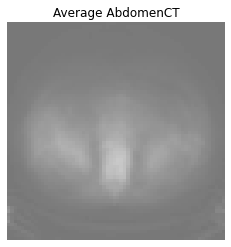

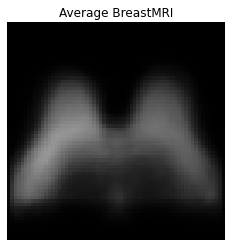

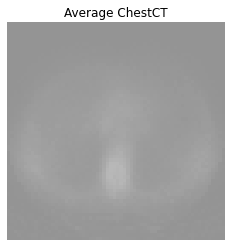

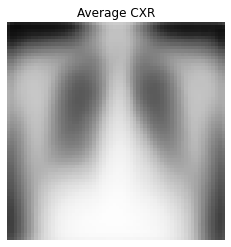

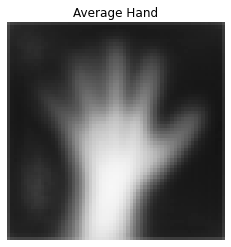

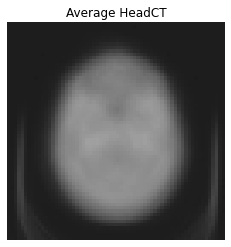

In [7]:
def mean_img(img, title, size=(IMAGE_SIZE, IMAGE_SIZE)):
    # calculate the mean of the image pixels across the dataset
    mean_img = np.mean(img, axis=0)
    # reshape the 1d vector back to the original image dimensions
    mean_img = mean_img.reshape(size)
    # plot the image
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img


AbdomenCT_mean = mean_img(AbdomenCT_imges, 'AbdomenCT')
BreastMRI_mean = mean_img(BreastMRI_imges, 'BreastMRI')
ChestCT_mean = mean_img(ChestCT_imges, 'ChestCT')
CXR_mean = mean_img(CXR_imges, 'CXR')
Hand_mean = mean_img(Hand_imges, 'Hand')
HeadCT_mean = mean_img(HeadCT_imges, 'HeadCT')

dict_of_means = {
    'AbdomenCT': AbdomenCT_mean,
    'BreastMRI': BreastMRI_mean,
    'ChestCT': ChestCT_mean,
    'CXR': CXR_mean,
    'Hand': Hand_mean,
    'HeadCT': HeadCT_mean
}

Now we can observe the difference between mean images of each class.

The contrast images show differences in pixel intensities that represent distinct features such as edges and shapes.

These differences justify the use of a Convolutional Neural Network (CNN) for classification.

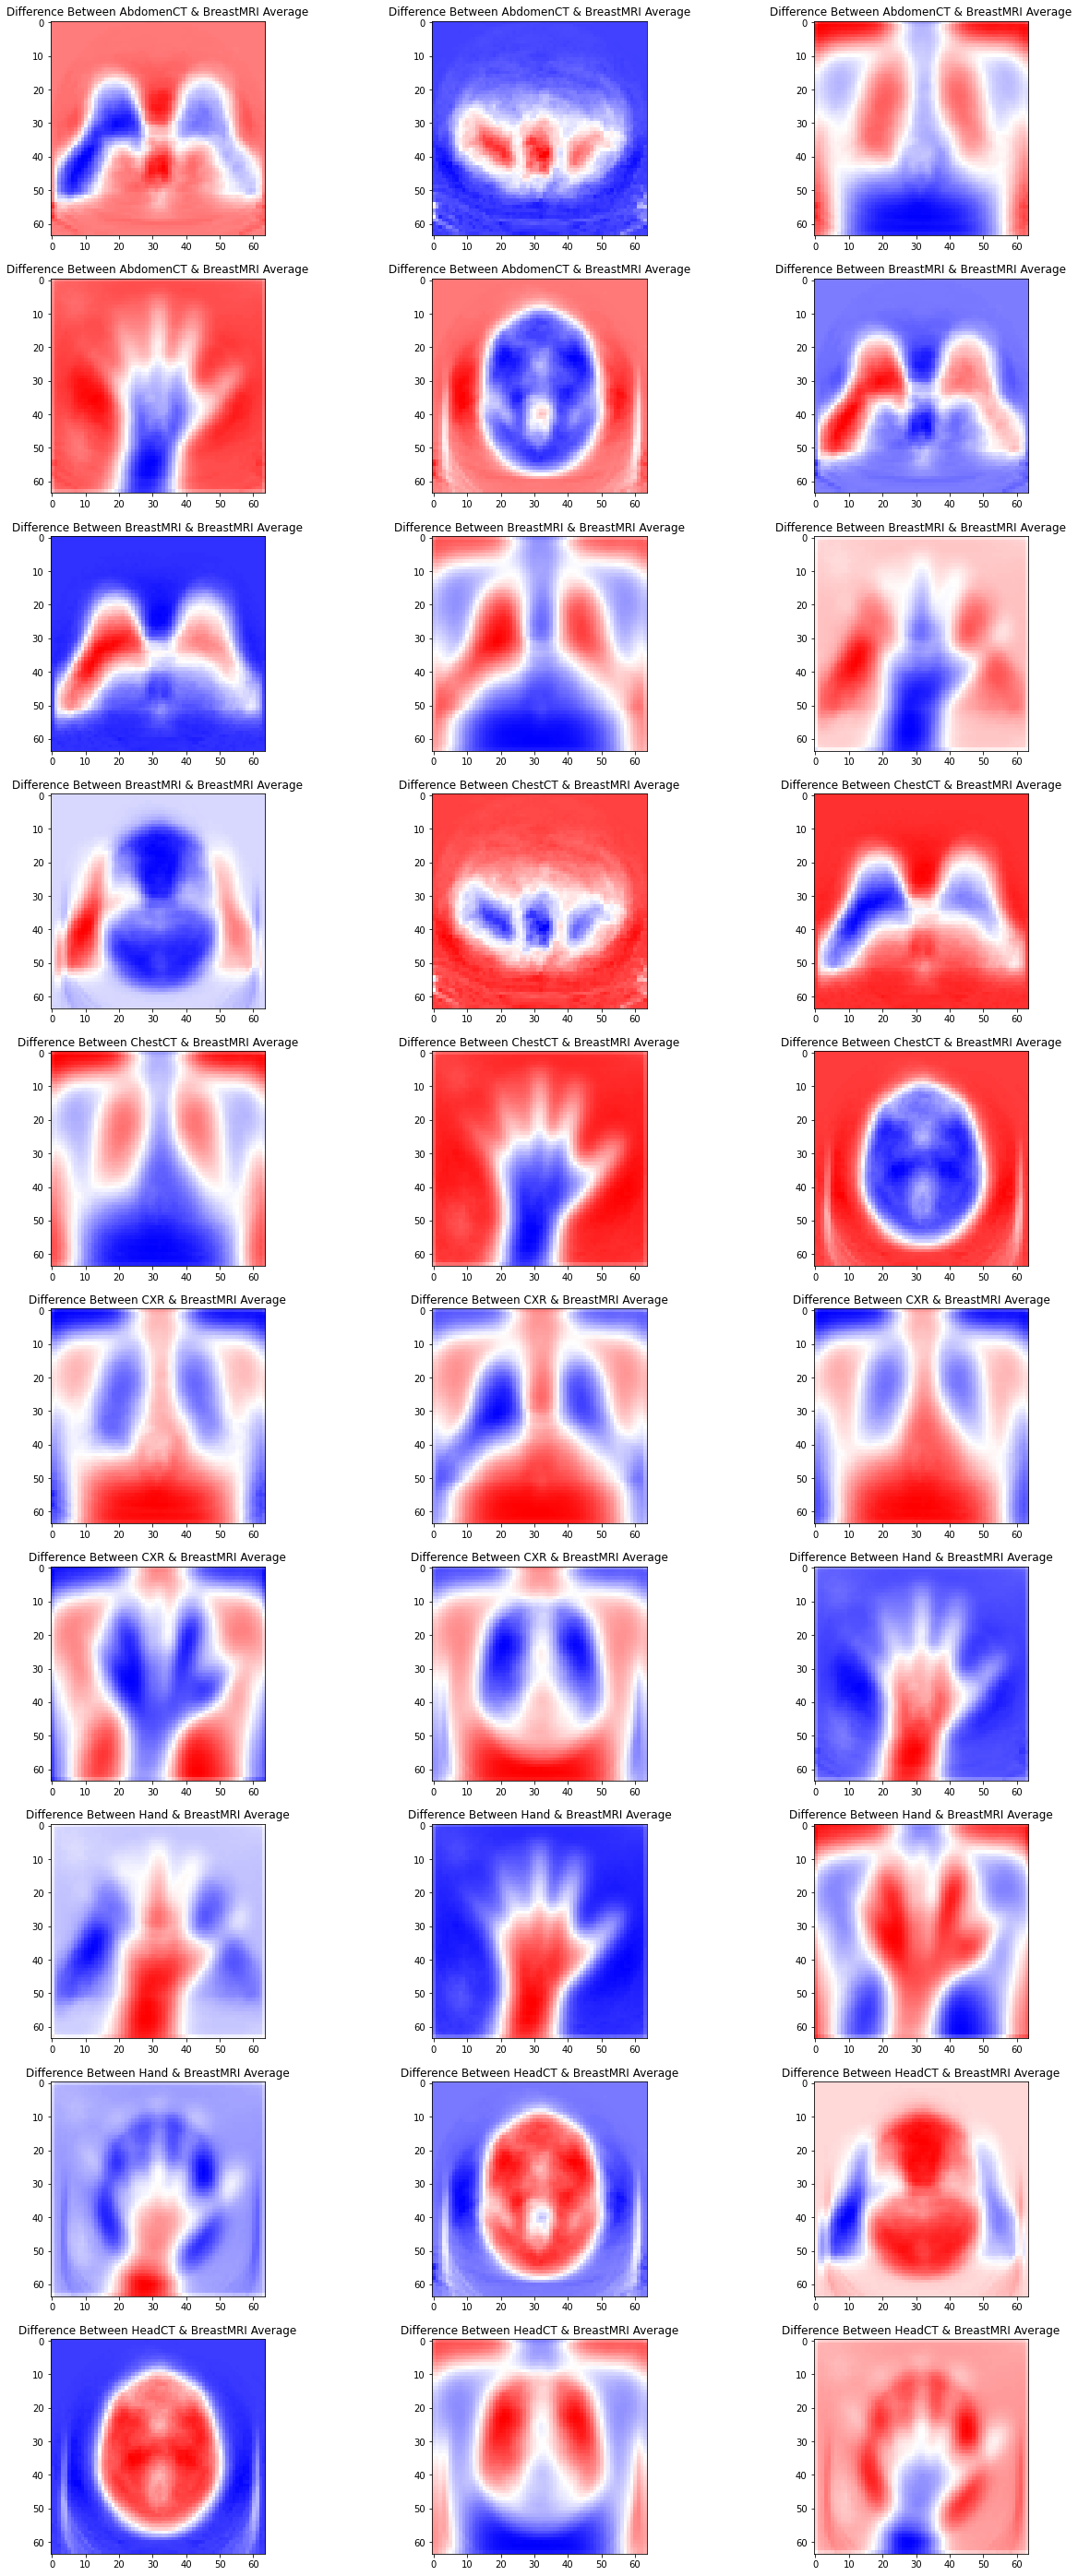

In [8]:
fig = plt.figure(figsize=(21, 50.5))
columns = 3
rows = 10
i = 1
for key1, value1 in dict_of_means.items():
    for key2, value2 in dict_of_means.items():
        if key1 == key2:
            continue
        contrast_mean = value1 - value2
        fig.add_subplot(rows, columns, i)
        plt.imshow(contrast_mean, cmap='bwr')
        plt.title('Difference Between ' + key1 + ' & BreastMRI Average')
        i = i + 1
plt.show()

As we can see, all classes differ significantly from each other in the intensity of pixels in different regions in the image. Classes also contain different types of edges and shapes. CNN is able to learn these features, and so we decided to choose it for the classification task.

# 02 Modeling

We now move to building the CNN model for image classification.

Convolutional Neural Network (CNN):
- A cnn applies convolution operations on images using filters (kernels) to extract features.
  Formula for convolution: `(f * g)(t) = ∫ f(τ) g(t - τ)dτ` (discrete version involves summation).
- `dropout`: a regularization method that randomly sets a fraction of neurons to 0 during training to prevent overfitting.
- `maxpool`: reduces spatial dimensions by taking the maximum value over a region.

In [9]:
%pip install torch
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


As a first step, we defined the CNN architecture with its layers. We also implement drop out for regularization with probability (0.25) described in Chapter 3.3.4. CNN architectures are described in detail in bachelor thesis in Chapter 3.4, and also described convolution principle, MaxPool and fully connected layers in Chapter 3.4 [1].

The forward function is used to pass the input vector through the network and calculate the loss function.
CNN class inspired by architecture in [4].

In [ ]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNN, self).__init__()
        # first convolutional layer: input channels -> 32 feature maps with 3x3 kernels
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=(3, 3))
        # first max pooling layer with 2x2 window and stride 2
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # second convolutional layer: 32 -> 16 feature maps with 3x3 kernels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3, 3))
        # second max pooling layer
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # flatten layer to convert 2d feature maps into a 1d vector
        self.flatten = nn.Flatten()
        # dropout layer with probability 0.25 for regularization
        self.dropout = nn.Dropout(0.25)
        self.lin1 = nn.Linear(3136, 64)
        # output layer that maps to the number of classes
        self.lin2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # apply first convolution, then relu activation
        x = F.relu(self.conv1(x))
        # apply first pooling layer
        x = self.pool1(x)
        # apply second convolution, then relu activation
        x = F.relu(self.conv2(x))
        # apply second pooling layer
        x = self.pool2(x)
        # flatten the output for the fully connected layers
        x = self.flatten(x)
        # apply dropout for regularization
        x = self.dropout(x)
        # apply first fully connected layer with relu activation
        x = F.relu(self.lin1(x))
        # output layer (logits) without activation since loss function applies softmax internally
        x = self.lin2(x)

        return x

## Selection of Hyperparameters and Training Details

Selection of hyperparameters (batch size, learning rate, epochs) is crucial for CNN performance.

Due to hardware limitations, training might take considerable time.
We achieved the best result with the parameters defined below.

***We achieved the best result on parameters defined below.***

In [11]:
# use cpu since no nvidia gpu is availabledevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# hyperparameters
in_channels = 1
num_classes = 6  #number of classes
lr = 0.001  #learning rate - determine the size of step in gradient descent
batch_size = 60  #number of images in one batch/mini-batch
num_epochs = 8  #number of epochs

## Loading the Dataset

We define a custom dataset class that loads images along with their labels.
This class inherits from `torch.utils.data.Dataset` and is inspired by previous implementations [5].

In [12]:
class MedicalMNIST(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.annotations = df  # classes of images
        self.root_dir = root_dir  # setting root dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])  # get path to the image
        image = io.imread(img_path)  # read image
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))  # label for image

        if self.transform:
            image = self.transform(image)  # transform dataframe

        return (image, y_label)  # return image with assigned label

We now load the image paths and labels into a dataframe.

In [13]:
mp = {}
df = []
for idx, category in enumerate(os.listdir("./data/medical_mnist")):
    mp[category] = idx
    for image in os.listdir("./data/medical_mnist/" + category):
        df.append([category + "/" + image, mp[category]])
df = np.array(df)
df = pd.DataFrame(df)
df.head()

0  1
0  AbdomenCT/000000.jpeg  0
1  AbdomenCT/000001.jpeg  0
2  AbdomenCT/000002.jpeg  0
3  AbdomenCT/000003.jpeg  0
4  AbdomenCT/000004.jpeg  0

We instantiate the custom dataset with the defined dataframe and transform the images to tensors.

In [14]:
dataset = MedicalMNIST(df=df, root_dir="./data/medical_mnist",
                       transform=transforms.ToTensor())

In [15]:
# train_set, test_set = torch.utils.data.random_split(dataset,
#                                                    [48954,10000])

We split the dataset into training and testing subsets using an 80:20 ratio.

In [16]:
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=1)

In [17]:
# load the data from subsets into the batches
train_loader = DataLoader(train_set, batch_size=(batch_size), shuffle=True)
test_loader = DataLoader(test_set, batch_size=(batch_size), shuffle=True)

## Creating the CNN Model

We create an instance of the CNN model defined earlier and move it to the appropriate device.

In [18]:
model = CNN(in_channels, num_classes).to(device)

# Loss function: cross entropy loss is used for multi-class classification.
criterion = nn.CrossEntropyLoss()

## Optimizer

We use the Adam optimizer, which combines RMSProp with momentum and includes bias correction [1].
Its update rule (simplified) is:
```
    m_t = β₁ * m_{t-1} + (1-β₁) * g_t
    v_t = β₂ * v_{t-1} + (1-β₂) * g_t²
    θ_t = θ_{t-1} - lr * m_t / (sqrt(v_t) + ε)
```
where `g_t` is the gradient at time `t`.

In [19]:
# set up the adam optimizer with the model parameters and defined learning rate
optimizer = optim.Adam(model.parameters(), lr=lr)

In [20]:
# examination of parameters
for parameter in model.parameters():
    print(parameter)

Parameter containing:
tensor([[[[ 0.1603,  0.2539, -0.2173],
          [ 0.2743,  0.2980,  0.0786],
          [ 0.2486, -0.2775,  0.1111]]],


        [[[ 0.0340,  0.1500,  0.1931],
          [ 0.1688,  0.1666,  0.2150],
          [-0.2329, -0.0641, -0.1273]]],


        [[[ 0.0806,  0.1130,  0.3057],
          [-0.0435, -0.2983, -0.1082],
          [ 0.1497, -0.2519,  0.0638]]],


        [[[-0.1707, -0.0925,  0.0811],
          [-0.0485, -0.2528,  0.2172],
          [-0.0796, -0.0251, -0.3053]]],


        [[[-0.2768, -0.0748,  0.1945],
          [ 0.2115,  0.1368,  0.0531],
          [ 0.2170, -0.2387,  0.2925]]],


        [[[ 0.2136,  0.1003, -0.1735],
          [ 0.2305, -0.1400, -0.0855],
          [ 0.2803,  0.2177,  0.1091]]],


        [[[-0.2760,  0.1635,  0.3025],
          [-0.1753, -0.1473,  0.2629],
          [-0.0138,  0.1459, -0.0528]]],


        [[[-0.1004, -0.2111,  0.1278],
          [-0.0927, -0.3218, -0.0590],
          [-0.2633,  0.0057, -0.0043]]],


        [[

In [21]:
import matplotlib.pyplot as plt


def my_plot(epochs, loss):
    plt.plot(epochs, loss)

# 03 Training the CNN

We train the network for a specified number of epochs using our training data loader.

For each epoch, we perform forward and backward passes and update the network weights using gradient descent.


In [22]:
# function for training the network for number of epochs. inspired by the training function in [5]

def train(model, num_epochs):
    loss_vals = []
    for epoch in range(num_epochs):
        epoch_loss = []
        for batch, (data, targets) in enumerate(train_loader):
            data = data.to(device=device)
            targets = targets.to(device=device)

            #Forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            #Backward pass
            optimizer.zero_grad()
            loss.backward()

            epoch_loss.append(loss.item())

            # Gradient descent
            optimizer.step()

        loss_vals.append(sum(epoch_loss) / len(epoch_loss))
        print(epoch, "Current Loss:", loss)
    return loss_vals


loss_vals = train(model, num_epochs)

0 Current Loss: tensor(0.0003, grad_fn=<NllLossBackward0>)
1 Current Loss: tensor(1.3868e-05, grad_fn=<NllLossBackward0>)
2 Current Loss: tensor(2.4000e-05, grad_fn=<NllLossBackward0>)
3 Current Loss: tensor(0.0001, grad_fn=<NllLossBackward0>)
4 Current Loss: tensor(1.3431e-05, grad_fn=<NllLossBackward0>)
5 Current Loss: tensor(1.1921e-06, grad_fn=<NllLossBackward0>)
6 Current Loss: tensor(3.9736e-08, grad_fn=<NllLossBackward0>)
7 Current Loss: tensor(2.7418e-06, grad_fn=<NllLossBackward0>)


## Visualization of Loss During Training

We plot the training loss over epochs to monitor convergence.

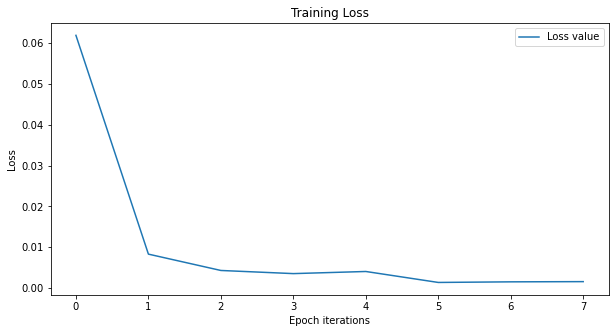

In [23]:
plt.figure(figsize=(10, 5))
plt.title("Training Loss")
plt.plot(loss_vals, label="Loss value")
plt.xlabel("Epoch iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Evaluation

Finally, we evaluate the model accuracy on both the training and testing subsets.

In [24]:
# function for evaluation of the model, inspired by the training function in [5]

def evaluate(loader, model):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            _, pred = scores.max(1)
            correct += (pred == y).sum()
            total += pred.size(0)
        print("Accuracy:", correct / total * 100, "%")


evaluate(train_loader, model)
evaluate(test_loader, model)

Accuracy: tensor(99.9534) %
Accuracy: tensor(99.8558) %


Our model was able to learn good sights on the training data and achieve high accuracy on testing subset, specifically accuracy was ***99.8558%***.